<a href="https://colab.research.google.com/github/chaudharynidhi/Bach-Chorales-Analysis/blob/master/Bach_Chorales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"

In [3]:
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT+FILENAME, extract=True,
                                cache_subdir='datasets/jsb_chorales')

122880/117661 [===============================] - 0s 0us/step


In [4]:
filepath

'/root/.keras/datasets/jsb_chorales/jsb_chorales.tgz'

In [5]:
jsb_chorales_dir = Path(filepath).parent

In [6]:
jsb_chorales_dir

PosixPath('/root/.keras/datasets/jsb_chorales')

In [7]:
train_files = sorted(jsb_chorales_dir.glob('train/chorale_*.csv'))
valid_files = sorted(jsb_chorales_dir.glob('valid/chorale_*.csv'))
test_files = sorted(jsb_chorales_dir.glob('test/chorale_*.csv'))

In [8]:
def chorale_load(filepaths):
  return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

In [9]:
train_data = chorale_load(train_files)
test_data = chorale_load(test_files)
valid_data = chorale_load(valid_files)

In [10]:
notes = set()
for chorales in (train_data, test_data, valid_data):
  for chorale in chorales:
    for chord in chorale:
      notes |= set(chord)

n_chords = len(notes)
min_chord = min(notes-{0})
max_chords = max(notes)
len(chorales)

76

In [11]:
assert min_chord==36
assert max_chords==81

In [12]:
def preprocess(window):
  window = tf.where(window==0, window, window-min_chord+1)
  #print(window.shape)
  window=tf.reshape(window,[-1])
  #print(window.shape)
  return window

def create_target(batch):
  X = batch[:, :-1]
  y = batch[:, 1:]
  return X,y

def batch_dataset(chorales, batch_size=32, shuffle_buffer_size=None, window_size=32, window_shift=16, cache=True):
  def batch_window(window):
    return window.batch(window_size+1)
  
  def to_windows(chorales):
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.window(window_size+1, window_shift, drop_remainder=True)
    return dataset.flat_map(batch_window)

  chorales = tf.ragged.constant(chorales, ragged_rank=1)
  dataset = tf.data.Dataset.from_tensor_slices(chorales)
  dataset = dataset.flat_map(to_windows).map(preprocess)

  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset=dataset.batch(batch_size)
  dataset=dataset.map(create_target)
  return dataset.prefetch(1)

In [13]:
train = batch_dataset(train_data, shuffle_buffer_size=1000)

In [14]:
test = batch_dataset(test_data)
valid = batch_dataset(valid_data)

In [15]:
n_embeddings = 5

In [16]:
model= keras.models.Sequential([
                                keras.layers.Embedding(input_dim=n_chords, output_dim=n_embeddings, input_shape=[None]),
                                keras.layers.Conv1D(16, kernel_size=4, padding='causal', activation='relu'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv1D(32, kernel_size=4, padding='causal', activation='relu'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv1D(64, kernel_size=4, padding='causal', activation='relu'),
                                keras.layers.BatchNormalization(),
                                keras.layers.Conv1D(128, kernel_size=4, padding='causal', activation='relu'),
                                keras.layers.BatchNormalization(),
                                keras.layers.LSTM(256, return_sequences=True ),
                                keras.layers.Dense(n_chords, activation='softmax')
])

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train, epochs=20, validation_data=valid)

Epoch 1/20
98/98 [==============================] - 72s 699ms/step - loss: 1.8202 - accuracy: 0.5373 - val_loss: 4.4182 - val_accuracy: 0.0778
Epoch 2/20
98/98 [==============================] - 62s 631ms/step - loss: 0.9151 - accuracy: 0.7630 - val_loss: 5.2881 - val_accuracy: 0.0691
Epoch 3/20
98/98 [==============================] - 62s 632ms/step - loss: 0.7842 - accuracy: 0.7868 - val_loss: 4.3899 - val_accuracy: 0.0856
Epoch 4/20
98/98 [==============================] - 62s 633ms/step - loss: 0.7088 - accuracy: 0.8009 - val_loss: 3.2688 - val_accuracy: 0.1318
Epoch 5/20
98/98 [==============================] - 62s 634ms/step - loss: 0.6530 - accuracy: 0.8123 - val_loss: 2.0194 - val_accuracy: 0.3122
Epoch 6/20
98/98 [==============================] - 65s 661ms/step - loss: 0.6080 - accuracy: 0.8221 - val_loss: 0.9792 - val_accuracy: 0.7120
Epoch 7/20
98/98 [==============================] - 63s 645ms/step - loss: 0.5672 - accuracy: 0.8316 - val_loss: 0.7239 - val_accuracy: 0.7923

In [ ]:
import matplotlib.pyplot as plt


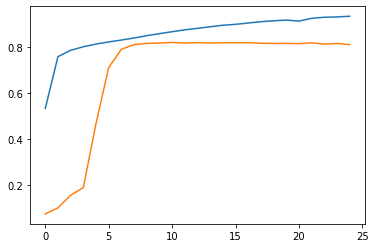

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [19]:
model.evaluate(test)

34/34 [==============================] - 5s 158ms/step - loss: 0.6778 - accuracy: 0.8139


[0.6778232455253601, 0.8139035701751709]

In [ ]:
model.save('bach_chorale.h5')